<a href="https://colab.research.google.com/github/yohanesmar/cheatsheet-and-theory/blob/main/Copy_of_trip_and_weather_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
weather_file_path = '/content/drive/MyDrive/S2/Business Intelligence and Analytics/Database/weather_train.xlsx'
trip_file_path = '/content/drive/MyDrive/S2/Business Intelligence and Analytics/Database/trip_train.csv'

In [ ]:
# Load the datasets
weather_df = pd.read_excel(weather_file_path)
trip_df = pd.read_csv(trip_file_path)

<ipython-input-5-9d0e66c61c12>:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  trip_df = pd.read_csv(trip_file_path)


In [ ]:
weather_df.head()

,Date,00.00 - 06.00,06.00 - 12.00,12.00 - 18.00,18.00 - 00.00
0,1 January,Overcast,Light Rain Overcast,Partly Sunny,Clear
1,2 January,Clear,Sunny,Sunny,Clear
2,3 January,Clear,Sunny,Overcast,Overcast
3,4 January,Overcast,Overcast,Scattered Clouds,Clear
4,5 January,Clear,Sunny,Sunny,Clear


Rest of the processing follows the same steps

In [ ]:
# Convert the tpep_pickup_datetime to datetime format for easy extraction of date and time
trip_df['tpep_pickup_datetime'] = pd.to_datetime(trip_df['tpep_pickup_datetime'], format='%a %b %d %H:%M:%S UTC %Y')

In [ ]:
# Extract date and hour from trip data
trip_df['trip_date'] = trip_df['tpep_pickup_datetime'].dt.date
trip_df['trip_hour'] = trip_df['tpep_pickup_datetime'].dt.hour

In [ ]:
# Reshape weather data
weather_df = pd.melt(weather_df, id_vars=['Date'], var_name='time_period', value_name='weather_condition')

In [ ]:
# Add start and end hours for time periods
time_period_mapping = {
    '00.00 - 06.00': (0, 6),
    '06.00 - 12.00': (6, 12),
    '12.00 - 18.00': (12, 18),
    '18.00 - 00.00': (18, 24)
}
weather_df['start_hour'], weather_df['end_hour'] = zip(*weather_df['time_period'].map(time_period_mapping))

In [ ]:
# Convert Date in weather data to datetime and assume year 2024
weather_df['weather_date'] = pd.to_datetime(weather_df['Date'] + ' 2024', format='%d %B %Y')

In [ ]:
# Merge the trip data with weather data by date
merged_df = pd.merge(
    trip_df,
    weather_df,
    how='left',
    left_on='trip_date',
    right_on=weather_df['weather_date'].dt.date
)

In [ ]:
# Filter the rows where trip hour matches the weather's time period
merged_df = merged_df[
    (merged_df['trip_hour'] >= merged_df['start_hour']) &
    (merged_df['trip_hour'] < merged_df['end_hour'])
]

In [ ]:
# Display the first few rows of the merged data
merged_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,congestion_surcharge,Airport_fee,trip_date,trip_hour,Date,time_period,weather_condition,start_hour,end_hour,weather_date
0,2,2024-01-01 00:57:55,Mon Jan 01 01:17:43 UTC 2024,1.0,1.72,1.0,N,186,79,2,...,2.5,0.0,2024-01-01,0,1 January,00.00 - 06.00,Overcast,0.0,6.0,2024-01-01
4,1,2024-01-01 00:03:00,Mon Jan 01 00:09:36 UTC 2024,1.0,1.80,1.0,N,140,236,1,...,2.5,0.0,2024-01-01,0,1 January,00.00 - 06.00,Overcast,0.0,6.0,2024-01-01
8,1,2024-01-01 00:17:06,Mon Jan 01 00:35:01 UTC 2024,1.0,4.70,1.0,N,236,79,1,...,2.5,0.0,2024-01-01,0,1 January,00.00 - 06.00,Overcast,0.0,6.0,2024-01-01
12,1,2024-01-01 00:36:38,Mon Jan 01 00:44:56 UTC 2024,1.0,1.40,1.0,N,79,211,1,...,2.5,0.0,2024-01-01,0,1 January,00.00 - 06.00,Overcast,0.0,6.0,2024-01-01
16,1,2024-01-01 00:46:51,Mon Jan 01 00:52:57 UTC 2024,1.0,0.80,1.0,N,211,148,1,...,2.5,0.0,2024-01-01,0,1 January,00.00 - 06.00,Overcast,0.0,6.0,2024-01-01


In [ ]:
# Get the total number of rows
total_rows = merged_df.shape[0]
# Print the total number of rows
print(f"Total number of rows: {total_rows}")

Total number of rows: 2964606


In [ ]:
# Convert the datetime columns to timezone-naive (i.e., without timezone information)
merged_df['tpep_pickup_datetime'] = pd.to_datetime(merged_df['tpep_pickup_datetime']).dt.tz_localize(None)
merged_df['tpep_dropoff_datetime'] = pd.to_datetime(merged_df['tpep_dropoff_datetime']).dt.tz_localize(None)

# Calculate trip duration (in minutes)
merged_df['trip_duration'] = (merged_df['tpep_dropoff_datetime'] - merged_df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [ ]:
# Define trip duration categories (e.g., short, medium, long trips)
# You can define your own thresholds here
bins = [0, 5, 15, float('inf')]  # Define bin edges for trip durations
labels = ['short', 'medium', 'long']  # Label each bin

In [ ]:
# Create a new categorical column in the data for trip duration classification
merged_df['trip_duration_category'] = pd.cut(merged_df['trip_duration'], bins=bins, labels=labels)

In [ ]:
# Display the distribution of categories
print(merged_df['trip_duration_category'].value_counts())

trip_duration_category
medium    1527054
long      1063136
short      373546
Name: count, dtype: int64


In [ ]:
# Convert categorical weather conditions into numerical categories
merged_df['weather_condition'] = merged_df['weather_condition'].astype('category').cat.codes

In [ ]:
merged_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,trip_date,trip_hour,Date,time_period,weather_condition,start_hour,end_hour,weather_date,trip_duration,trip_duration_category
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,...,2024-01-01,0,1 January,00.00 - 06.00,13,0.0,6.0,2024-01-01,19.800000,long
4,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,...,2024-01-01,0,1 January,00.00 - 06.00,13,0.0,6.0,2024-01-01,6.600000,medium
8,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,...,2024-01-01,0,1 January,00.00 - 06.00,13,0.0,6.0,2024-01-01,17.916667,long
12,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,...,2024-01-01,0,1 January,00.00 - 06.00,13,0.0,6.0,2024-01-01,8.300000,medium
16,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,...,2024-01-01,0,1 January,00.00 - 06.00,13,0.0,6.0,2024-01-01,6.100000,medium


In [ ]:
# Save the merged dataframe as a CSV file
merged_df.to_csv('trip_and_weather_train.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('trip_and_weather_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Select features for prediction (trip distance, passenger count, weather, etc.)
features = ['trip_distance', 'passenger_count', 'trip_hour', 'weather_condition']

In [ ]:
# Prepare the input (X) and output (y) data
X = merged_df[features]
y = merged_df['trip_duration']

In [ ]:
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Make predictions and evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Forest - MAE: {mae}")

Forest - MAE: 5.4506295324218454


In [ ]:
# Prepare the features (X) and target (y) for classification
X_classification = merged_df[features]  # Same features as before
y_classification = merged_df['trip_duration_category'].cat.codes

In [ ]:
# Split the data into training and test sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

In [ ]:
# Handle missing values using SimpleImputer (for classification task)
imputer = SimpleImputer(strategy='mean')  # Fill missing values with the mean
X_train_class_imputed = imputer.fit_transform(X_train_class)
X_test_class_imputed = imputer.transform(X_test_class)

In [ ]:
# Train a Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_class_imputed, y_train_class)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict probabilities for the test set
y_prob_class = classifier.predict_proba(X_test_class_imputed)  # Get probabilities for class "1" (positive class)

In [ ]:
# Compute ROC curve and AUC score
auc_score = roc_auc_score(y_test_class, y_prob_class, multi_class='ovr')
# Print AUC score
print(f'AUC Score: {auc_score}')

AUC Score: 0.8780081786926955


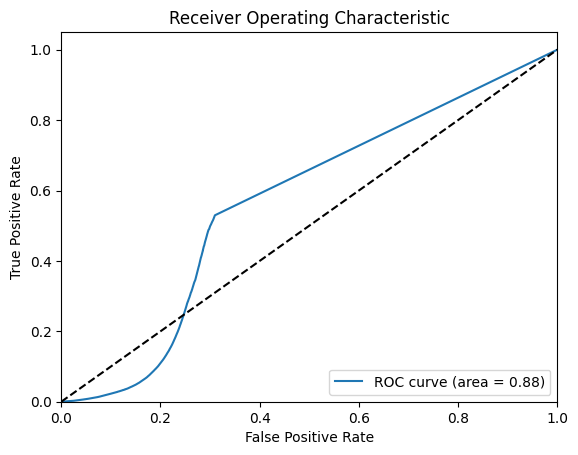

In [ ]:
# Compute ROC curve for class 1 (One-vs-Rest)
fpr, tpr, thresholds = roc_curve(y_test_class, y_prob_class[:, 1], pos_label=1)
# Plot the ROC Curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()